Imports et constantes

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import operator
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model as lm
from sklearn.utils import DataConversionWarning
import statsmodels.api as sm
from matplotlib import cm, pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pink = '#FF1493'
warnings.simplefilter('ignore', np.VisibleDeprecationWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', DataConversionWarning)

## Fonctions utiles
def linear_fit(x, y):
    
    X = x.reshape(-1, 1) if type(x) == pd.Series else x
    clf = lm.LinearRegression()
    clf.fit(X, y)
    return X, clf

def checkEqual(a, b):
    if np.isclose(a, b):
        print("Les deux termes sont égaux")
    else:
        print(str(a) + ' != ' + str(b))
        

# Centrer et réduire les données:
def centrer_reduire(x):
    if type(x) == pd.Series:
        return StandardScaler().fit_transform(x)
    if type(x) == pd.DataFrame:
        x_copy = pd.DataFrame()
        for col in x.columns:
            x_copy[col] = StandardScaler().fit_transform(x[col])
        return x_copy
    raise TypeError('type not supported: ' + str(type(x)))
    

# EXERCICE 1

### 1) Récupérer les données du fichier et transformer les tailles en cm

In [2]:
df = pd.read_csv("http://www.math.uah.edu/stat/data/Galton.csv")

# 1 inch = 2.54cm
cols = ['Father', 'Mother', 'Height']
df[cols] = np.round(2.54 * df[cols])

### 2) Combien de données manquantes? Enlever si besoin les lignes correspondantes

In [3]:
nb_lignes_avec_donnes_manquantes = df.shape[0] - df.dropna(axis=0).shape[0]
if nb_lignes_avec_donnes_manquantes > 0:
    df = df.dropna(axis=0)

### 3) Afficher un estimateur de la densité de la population des père en bleu, et de celle des mères en violet

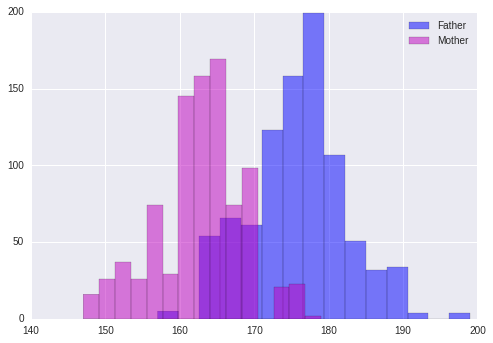

In [4]:
plt.hist(df['Father'], bins=15, alpha=0.5, label='Father', color='b')
plt.hist(df['Mother'], bins=15, alpha=0.5, label='Mother', color='m')
plt.legend(loc='upper right')
plt.show()

### 4) Taille du père en fonction de la taille de la mère, avec prédiction

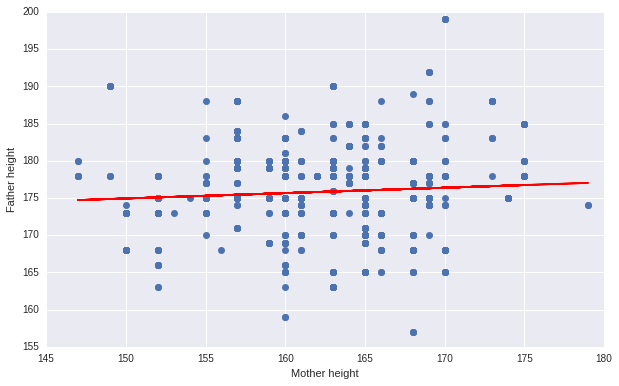

In [5]:
(X, clf) = linear_fit(df['Mother'], df['Father'])

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel("Mother height")
ax.set_ylabel("Father height")
ax.plot(X[:,], df['Father'], 'o')
ax.plot(X[:,], clf.predict(X), 'r')
plt.show()

### 5) Afficher un histogramme du nombre d’enfants par famille

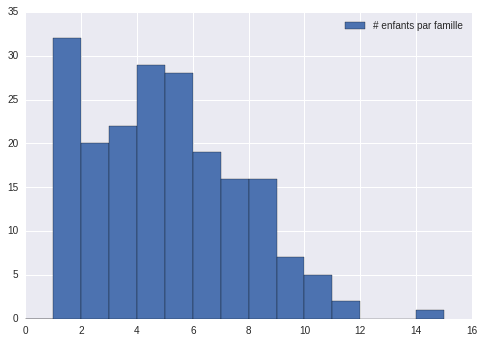

In [6]:
plt.hist(df['Family'].value_counts(), range(16), label='# enfants par famille')
plt.legend(loc='upper right')
plt.show()

### 6) Créer une colonne supplémentaire 'MeanParents'

In [7]:
df['MeanParents'] = 0.5 * (df['Father'] + 1.08 * df['Mother'])

### 7)  Estimer θ0 et θ1 par θ̂0 et θ̂1 en utilisant la fonction LinearRegression de sklearn, puis vérifier numériquement les formules vues en cours pour le cas unidimensionnel

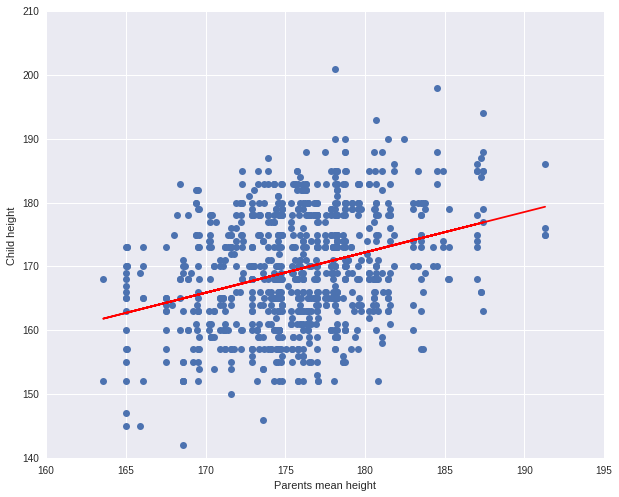

58.255916588
0.633093766663
Les deux termes sont égaux
Les deux termes sont égaux


In [8]:
x = df['MeanParents']
y = df['Height']

(X, clf) = linear_fit(x,y)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(X[:,], y, 'o')
ax.plot(X[:,], clf.predict(X), 'r')
ax.set_xlabel("Parents mean height")
ax.set_ylabel("Child height")
plt.show()

(theta0, theta1) = (clf.intercept_, clf.coef_[0])
print(theta0)
print(theta1)

checkEqual(theta0, y.mean() - theta1 * x.mean())
checkEqual(theta1, np.cov(x, y)[0, 1] /  np.cov(x))

### 8) Calculer et visualiser les valeurs prédites ŷi = θ̂0 + θ̂1 * xi et les yi sur un même graphique. On affichera de deux couleurs différentes les garçons et les filles

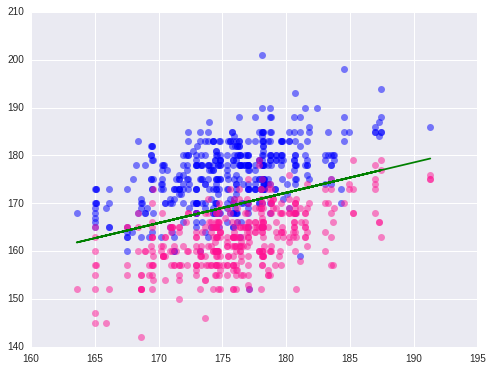

In [9]:
b = df[df['Gender']=='M']
g = df[df['Gender']=='F']

xb, yb = b['MeanParents'], b['Height']
xg, yg = g['MeanParents'], g['Height']

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(xb, yb, 'o', color='b',  alpha=0.5)
ax.plot(xg, yg, 'o', color=pink, alpha=0.5)
ax.plot(x, clf.predict(x.reshape(-1,1)), color='g')
plt.show()

### 9) Visualiser un estimateur de la densité des résidus ri = yi - ŷi. L’hypothèse de normalité est-elle crédible selon vous ? On ajoutera ensuite un estimateur par genre de la densité des résidus (en mettant un facteur proportionnel au nombre de personnes de chaque genre)

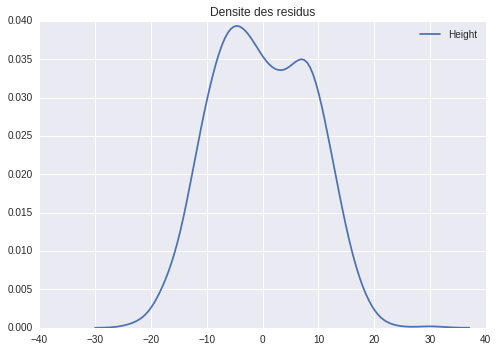

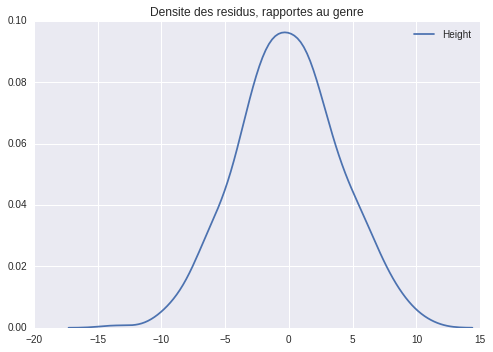

In [10]:
residus = y - clf.predict(X)

sns.kdeplot(residus)
plt.title('Densite des residus')
plt.show()

# À partir de la forme de l'histogramme, l'hypothèse de normalité semble crédible
rb = yb - clf.predict(xb.reshape(-1,1))
rg = yg - clf.predict(xg.reshape(-1,1))

nb, ng = len(b), len(g)
rb = rb.reset_index(drop=True)
rg = rg.reset_index(drop=True)
sns.kdeplot((nb*rb + ng*rg) / len(y))
plt.title('Densite des residus, rapportes au genre')
plt.show()

### 10) Régresser cette fois les xi sur les yi. Comparer les coefficients α̂0 et α̂1 obtenus par rapport aux θ̂0 et θ̂1 du modèle original. Vérifier numériquement que ...

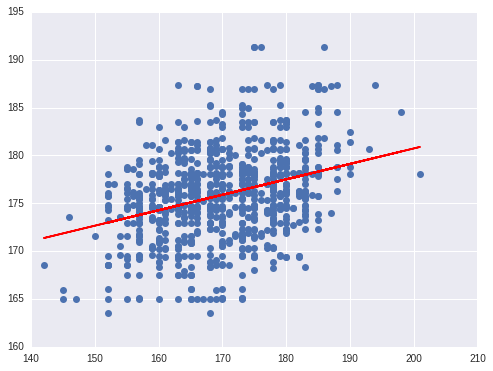

Les deux termes sont égaux
Les deux termes sont égaux


In [11]:
(Y, clf) = linear_fit(y, x)

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(y, x, 'o')
ax.plot(y, clf.predict(Y), 'r')
plt.show()

(alpha0, alpha1) = (clf.intercept_, clf.coef_[0])

(xm, ym) = x.mean(), y.mean()
checkEqual(alpha0, xm + ym*np.cov(x)*(theta0 - ym) / (xm*np.cov(y)))
checkEqual(alpha1, theta1 * np.cov(x) / np.cov(y))

## On travaille ici avec la même base de données, mais cette fois on considère un modèle de régression avec les deux variables explicatives 'Father' et 'Mother'

### 11) Calculer θ̂, ŷ pour ce modèle, respectivement l’estimateur des moindres carrés et le vecteur de prédiction

In [12]:
x = df[['Father', 'Mother']]
_, clf = linear_fit(x, y)
theta = [clf.intercept_]
theta.extend(clf.coef_)
print('theta_chap = ' + str(theta))
y_chap = clf.predict(x)

theta_chap = [57.694626126911544, 0.38230790501762374, 0.27426567479142744]


### 12) Afficher les points et leur prédiction sur un même graphique 3D

In [13]:
%matplotlib qt

fig1 = plt.figure(dpi=90, figsize=(16,14))
ax = fig1.add_subplot(111, projection='3d')
ax.set_xlabel("Father")
ax.set_ylabel("Mother")
ax.set_zlabel("Child")
ax.scatter(df['Father'], df['Mother'], y)

r = np.arange(140, 210)
X1, X2 = np.meshgrid(r, r)
Z = clf.predict(np.c_[X1.ravel(), X2.ravel()])
ax.plot_wireframe(X1, X2, Z.reshape(X1.shape), rstride=5, cstride=5, color="red")
plt.show()

### 13) Calculer le carré de la norme du vecteur des résidus ||r||² , avec ri = yi - ŷi

In [14]:
residus = y - y_chap
np.linalg.norm(residus)**2

66544.795587813191

### 14) Visualiser un estimateur de la densité des résidus. L’hypothèse de normalité est-elle crédible selon vous ? On ajoutera ensuite un estimateur par genre de la densité des résidus (en mettant un facteur proportionnel au nombre de personnes de chaque genre)

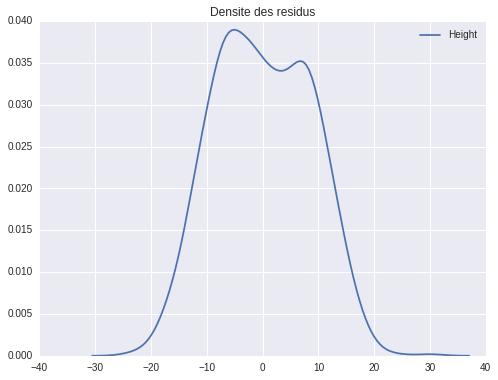

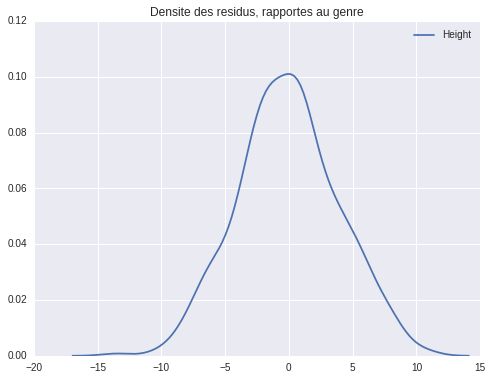

In [15]:
%matplotlib inline

fig = plt.figure(figsize=(8, 6))
sns.kdeplot(residus)
plt.title('Densite des residus')
plt.show()

xb, xg = b[['Father', 'Mother']], g[['Father', 'Mother']]

# Étant donnée la répartition des résidus, l'hypothèse de normalité ne semble pas être suffisante
rb = yb - clf.predict(xb)
rg = yg - clf.predict(xg)

rb = rb.reset_index(drop=True)
rg = rg.reset_index(drop=True)
fig = plt.figure(figsize=(8, 6))
sns.kdeplot((nb*rb + ng*rg) / len(y))
plt.title('Densite des residus, rapportes au genre')
plt.show()

### 15)  Comparer l’influence des deux variables. Laquelle semble la plus explicative ? Tester avant et après centrage et réduction des données.

In [16]:
# En comparant les coefficients obtenus par régression linéaire:
clf.fit(df[['Father', 'Mother']], y)
theta_non_cr = [clf.intercept_]
theta_non_cr.extend(clf.coef_)
print("\nNon centré-réduit: " + str(theta_non_cr))

# En centrant et réduisant les variables explicatives:
df_cr = centrer_reduire(df[['Father', 'Mother']])
clf.fit(df_cr, y)
theta_cr = [clf.intercept_]
theta_cr.extend(clf.coef_)
print("Centré-réduit: " + str(theta_cr))

# On trouve, avant et après réduction, que le plus fort coefficient 
# est devant 'Father' (theta1 > theta2)



Non centré-réduit: [57.694626126911544, 0.38230790501762374, 0.27426567479142744]
Centré-réduit: [169.56681514476614, 2.3729580842447637, 1.6183265109707778]


# EXERCICE 2

### 1) Importer les données, ajouter le nom des colonnes. Quel est le marqueur pour les données manquantes? Enlever les lignes concernées.

In [17]:
names = [
    'mpg',
    'cylinders',
    'displacement',
    'horsepower',
    'weight',
    'acceleration',
    'model year',
    'origin',
    'car name'
]

typos = {
    'chevy': 'chevrolet',
    'chevroelt': 'chevrolet',
    'mercedes-benz': 'mercedes',
    'toyouta': 'toyota',
    'vokswagen': 'volkswagen',
    'vw': 'volkswagen',
    'maxda': 'mazda'
}

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original"
df_original = pd.read_csv(url, sep=r"\s+", names=names)

# On retire les colonnes contenant des données discrètes (j'en profite pour mettre un peu d'ordre dans les marques)
origins = df_original['origin']

car_names_fixed = []
for car_name in df_original['car name']:
    for typo, fix in typos.items():
        if typo in car_name:
            car_name = fix
            continue
    car_names_fixed.append(car_name.split()[0])
df_original['brand'] = car_names_fixed
df_original = df_original.drop('car name', 1)

df = df_original.drop('origin', 1).drop('brand', 1)

# "NA" indique une donnée manquante
nb_lignes_avec_donnes_manquantes = df.shape[0] - df.dropna(axis=0).shape[0]
print(str(nb_lignes_avec_donnes_manquantes) + " lignes ont des données manquantes.")

# On retire les lignes rencontrées précedemment:
df = df.dropna(axis=0)
df_original = df_original.dropna(axis=0)

print(df.shape)
df.head()

14 lignes ont des données manquantes.
(392, 7)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model year
0,18.0,8.0,307.0,130.0,3504.0,12.0,70.0
1,15.0,8.0,350.0,165.0,3693.0,11.5,70.0
2,18.0,8.0,318.0,150.0,3436.0,11.0,70.0
3,16.0,8.0,304.0,150.0,3433.0,12.0,70.0
4,17.0,8.0,302.0,140.0,3449.0,10.5,70.0


### 2) Calculer l’estimateur des moindres carrés θ̂ et sa prédiction ŷ sur une sous partie de la base obtenue en gardant les 9 premières lignes. Que constatez-vous pour les variables 'cylinders' et 'model year'?

In [18]:
x = df.drop('mpg', 1)
y = df['mpg']

_, clf = linear_fit(x[:9], y[:9])

theta_chap = [clf.intercept_]
theta_chap.extend(clf.coef_)
print("theta_chap = \n" + str(theta_chap))

y_chap = clf.predict(x[:9])
print("\ny_chap = \n" + str(y_chap))

# On voit que theta1 et theta6, coef respectivement de cylinders et model year,
# sont nuls, c'est-à-dire qu'ils ne semblent pas influer sur MPG

theta_chap = 
[30.771695365621849, 0.0, 0.054088475668277548, -0.094530596162000061, -0.0042407367063116569, -0.19936701268572862, 0.0]

y_chap = 
[ 17.83593432  16.15135218  17.02803274  16.08414928  17.15247702
  14.85588522  14.27266143  14.2658702   13.35363761]


### 3) Calculer θ̂ et ŷ cette fois sur l’intégralité des données, après les avoir centrées et réduites. Quelles sont les deux variables qui expliquent le plus la consommation d’un véhicule ?

In [19]:
# centrer, réduire:
x_cr = centrer_reduire(x)
clf.fit(x_cr, y)

theta_chap = [clf.intercept_]
theta_chap.extend(clf.coef_)

print("column".center(12) + "coef".center(12))
for i, col in enumerate(x_cr.columns):
    print(col.ljust(12) + "{0:.4f}".format(theta_chap[i+1]).center(11))

print(theta_chap[0])
y_chap = clf.predict(x_cr)
y_chap[:20]



   column       coef    
cylinders     -0.5619  
displacement   0.8025  
horsepower    -0.0150  
weight        -5.7640  
acceleration   0.2350  
model year     2.7717  
23.4459183673


array([ 15.08291904,  14.07257469,  15.53631544,  15.53447451,
        15.28640745,  10.13543367,  10.14518132,  10.2823774 ,
         9.75375835,  13.04735326,  15.07939657,  14.27003871,
        13.82978602,  18.85175174,  22.8737646 ,  19.77703076,
        20.18480893,  21.5104138 ,  24.35531011,  26.88779881])

### 4) Calculer ||r||² (le carré de la norme du vecteur des résidus), puis ||r||² / (n - p). Vérifier numériquement que:
### ||y-yn.1n||² = ||r||² + ||ŷ-yn||²

In [20]:
sq_norm_residus = np.linalg.norm(y - y_chap)**2
n = len(y)
p = len(x.columns)
print("|r|²/(n-p) = " + str(sq_norm_residus / (n - p)))

y_mean = y.mean()
m_gauche = sum([(y_i - y_mean)**2 for y_i in y])
m_droite = sq_norm_residus + sum([(y_i - y_mean)**2 for y_i in y_chap])

checkEqual(m_gauche, m_droite)

|r|²/(n-p) = 11.7703290796
Les deux termes sont égaux


### 5) Prédire la consommation du nouveau véhicule

In [21]:
d = pd.DataFrame({
    'cylinders':    6,
    'displacement': 225,
    'horsepower':   100,
    'weight':       3233,
    'acceleration': 15.4,
    'model year':   76
}, index=[0])

# centre, reduire le nouveau vecteur
scales = x.apply(lambda x: StandardScaler().fit(x))
print(d)
for col in d.columns:
    d[col] = scales[col].transform(d[col])
print(d)
print("Valeur prédite: " + str(clf.predict(d)))

   acceleration  cylinders  displacement  horsepower  model year  weight
0          15.4          6           225         100          76    3233
   acceleration  cylinders  displacement  horsepower  model year    weight
0     -0.051292   0.309967      0.292679   -0.116263    0.005547  0.301085
Valeur prédite: [ 25.22502903]


### 6) Utiliser la transformation PolynomialFeatures de sklearn sur les données brutes, pour ajuster un modèle d’ordre 2 (avec interaction_only=False). On normalisera et recentrera après avoir créé les nouvelles variables explicatives

In [31]:
poly = PolynomialFeatures(2, interaction_only=False)
poly.fit(x)

features = list(x.columns)
poly_features = []

# Bouche qui génère les noms des colonnes de degré 2, retourne une liste
# do type ['x1', 'x6', 'x1²', 'x1 x x2', 'x]
for powers in poly.powers_:
    combined_features = []
    for i, power in enumerate(powers):
        if power == 1:
            combined_features.append(features[i])
        elif power == 2:
            combined_features.append(features[i] + '²')
    poly_features.append(' x '.join(combined_features))

x_poly = pd.DataFrame(poly.transform(x), columns=poly_features)

# PolynomialFeatures ajoute une colonne de 1 que nous ne voulons pas
x_poly = x_poly.drop('', 1)

# On centre réduit
x_poly_cr = centrer_reduire(x_poly)

# Puis on entraîne notre modèle
_, clf = linear_fit(x_poly_cr, y)
print(clf.intercept_)

for col, coef in zip(x_poly.columns, clf.coef_):
    print(col.ljust(30) + ": {c:.2f}".format(c=coef))

23.4459183673
cylinders                     : 13.34
displacement                  : -48.43
horsepower                    : 5.15
weight                        : 17.47
acceleration                  : -16.05
model year                    : -26.88
cylinders²                    : -8.13
cylinders x displacement      : -2.95
cylinders x horsepower        : 11.95
cylinders x weight            : 5.34
cylinders x acceleration      : 4.88
cylinders x model year        : -16.23
displacement²                 : 1.30
displacement x horsepower     : 3.38
displacement x weight         : 5.20
displacement x acceleration   : -3.29
displacement x model year     : 43.68
horsepower²                   : -3.59
horsepower x weight           : -6.15
horsepower x acceleration     : -2.39
horsepower x model year       : -4.85
weight²                       : 3.16
weight x acceleration         : 0.85
weight x model year           : -25.12
acceleration²                 : 1.99
acceleration x model year     : 13.91
mo

### 7) Proposer une manière de gérer la variable origin, par exemple avec pd.get_dummies. On ajustera un modèle linéaire sans constante dans ce cas. Déterminer laquelle des trois origines est la plus efficace en terme de consommation

In [ ]:
origin_correspondance = {
    1.0: 'usa',
    2.0: 'europe',
    3.0: 'japan'
}

dumdum = pd.get_dummies(df_original['origin']).reset_index(drop=True)
x_with_origins = x_cr.copy()

# Use the name of the origin instead of 1.0, 2.0 and 3.0:
for col in dumdum.columns:
    x_with_origins[origin_correspondance[col]] = dumdum[col]

_, clf = linear_fit(x_with_origins, y)
print(clf.intercept_)
print(clf.coef_)

mpg_per_origin = {}
# We want the index of the "len(origins)" last columns to retrieve 
# the correct coef from clf
for i, origin in enumerate(x_with_origins.columns[-len(dumdum.columns):]):
    mpg_per_origin[brand] = clf.coef_[len(x_cr.columns) + i]

i = 1
print("MPG per brand:\n")
for brand, mpg in sorted(mpg_per_brand.items(), key=operator.itemgetter(1), reverse=True):
    print(str(i) + ') ' + brand.capitalize().ljust(11) + " {m:2.2f}".format(m=mpg))
    print('-' * 20)
    i += 1

### 8) Procéder de même cette fois en fonction de la marque de la voiture

In [ ]:
dumdum = pd.get_dummies(df_original['brand']).reset_index(drop=True)
brands = dumdum.columns

x_with_brands = x_cr.copy()
x_with_brands[brands] = dumdum

_, clf = linear_fit(x_with_brands, y)

mpg_per_brand = {}
# We want the index of the "len(brands)" last columns to retrieve 
# the correct coef from clf
for i, brand in enumerate(x_with_brands.columns[-len(brands):]):
    mpg_per_brand[brand] = clf.coef_[len(x_cr.columns) + i]

i = 1
print("MPG per brand:\n")
for brand, mpg in sorted(mpg_per_brand.items(), key=operator.itemgetter(1), reverse=True):
    print(str(i) + ') ' + brand.capitalize().ljust(11) + " {m:2.2f}".format(m=mpg))
    print('-' * 20)
    i += 1
    
# La marque la plus efficace est Triumph...

### 9) Reprendre la matrice X obtenue sans variables catégorielles. Obtenez numériquement la SVD de X=U.S.transp(V); vérifier numériquement que H=U.transp(U) est une projection orthogonale. La diagonale de cette matrice forme le vecteur des “leviers” qu’on ajoutera comme nouvelle variable. Trier la base de données en fonction de cette nouvelle variable, et expliquer en quoi les voitures qui ont les trois plus grands niveaux de “levier” sont atypiques

In [ ]:
svd = np.linalg.svd(x, full_matrices=False)
u = svd[0]
h = np.dot(u, np.transpose(u))
if np.isclose(h, np.dot(h, h)).all():
    print("H est bien un projecteur orthogonal, car H.H = H")

x['leviers'] = [h[i][i] for i in range(len(h[0]))]
x.sort_values('leviers', ascending=False)[:10]